In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sp
import numpy.random as npr  
import scipy.stats as scs
import matplotlib.pyplot as plt
import numpy.random as npr
import seaborn as sns

from math import sqrt, exp
from pylab import plot, show, grid, xlabel, ylabel

## Simulation of BTC and LTV Process with SVCJ Model

In [2]:
# SVCJ parameters, from Hou et al.
mu      = 0.041
r       = mu
mu_y    = -0.084
sigma_y = 2.155
l       = 0.041
alpha   = 0.01
beta    = -0.132
rho     = 0.407
sigma_v = 0.008
rho_j   = -0.573
mu_v    = 0.62

kappa   = 1-beta
theta   = alpha / kappa

v0      = theta
#v0      = 0.19**2

In [3]:
m       = 365      # time horizon in days
dt      = 1/m      # dt
n       = 10000    # number of paths

In [4]:
T      = m * dt
time   = np.linspace(0.0, 12.0, m+1)

In [5]:
npr.seed(202006)
w      = npr.standard_normal([n,m])
w2     = rho * w + sp.sqrt(1-rho**2) * npr.standard_normal([n,m])
z_v    = npr.exponential(mu_v, [n,m])
z_y    = npr.standard_normal([n,m]) * sigma_y + mu_y + rho_j * z_v
dj     = npr.binomial(1, l * dt, size=[n,m])

s      = np.empty([n,m+1])
ltv    = np.empty([n,m+1])
v      = np.empty([n,m+1])

In [6]:
K = 0.9    # liquidization threshold
D = 0.8    # danger zone

#bitcoin value on 12/06/2020
s0 = 9425.92
ltv0 = 0.6

# fix collateral size for 1 BTC for calculation of LTV ratios
CS = ltv0*s0 

# set starting values
s[:,0]   = s0  
ltv[:,0] = ltv0
v[:,0]   = v0

In [7]:
# computation of the processes
for i in range(1,m+1):
    v[:,i] = v[:,i-1] + kappa * (theta - np.maximum(0,v[:,i-1])) * dt + sigma_v * sp.sqrt(np.maximum(0,v[:,i-1])) * w2[:,i-1] + z_v[:,i-1] * dj[:,i-1]
    s[:,i] = s[:,i-1] * (1 + (r - l * (mu_y + rho_j * mu_v)) * dt + sp.sqrt(v[:,i-1] * dt) * w[:,i-1]) + z_v[:,i-1] * dj[:,i-1]
    ltv[:,i] = CS/s[:,i]

C:\Users\Ramona\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


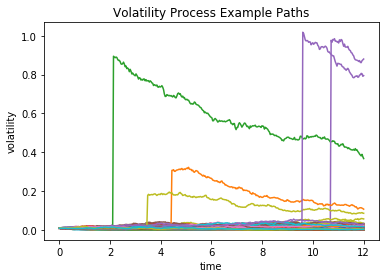

In [8]:
for k in range(100):
    plot(time, v[k])
    
xlabel('time')
ylabel('volatility')
plt.title('Volatility Process Example Paths')
#plt.savefig('fig1.png', transparent=True)
plt.show()

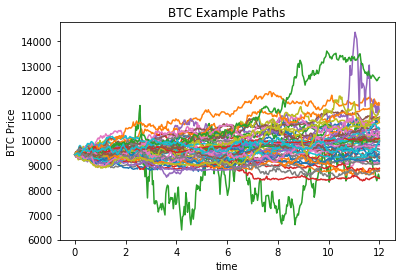

In [9]:
for k in range(50):
    plot(time, s[k])  
    
xlabel('time')
ylabel('BTC Price')
plt.title('BTC Example Paths')
#plt.savefig('fig2.png', transparent=True)
plt.show()

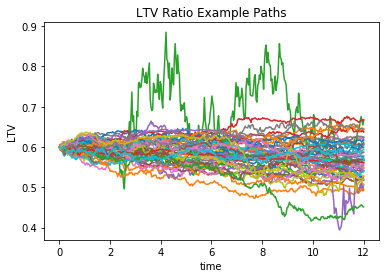

In [10]:
for k in range(50):
    plot(time, ltv[k])
    
xlabel('time')
ylabel('LTV')
plt.title('LTV Ratio Example Paths')
#plt.savefig('fig3.png', transparent=True)
plt.show()

In [11]:
y=np.argwhere(ltv>=0.9)
y[np.argwhere(y[:,1:]<=60)][0,0]

array([6092,   40], dtype=int64)

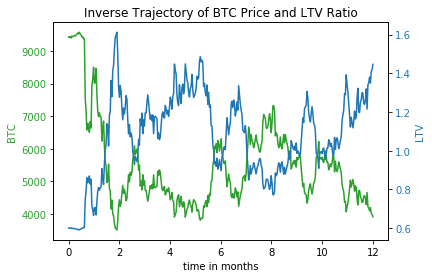

In [12]:
# example to show inverse movement
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('time in months')
ax1.set_ylabel('BTC', color=color)
ax1.plot(time, s[6092], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('LTV', color=color)  
ax2.plot(time, ltv[6092], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Inverse Trajectory of BTC Price and LTV Ratio') 
#plt.savefig('fig4.png', transparent=True)
plt.show()

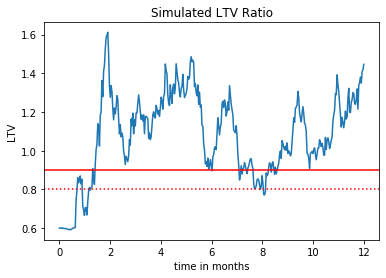

In [13]:
plot(time, ltv[6092])
xlabel('time in months')
ylabel('LTV')
plt.title('Simulated LTV Ratio')
plt.axhline(y=K, color='r', linestyle='-')
plt.axhline(y=0.8, color='r', linestyle='dotted')
#plt.savefig('fig5.png', transparent=True)
show()

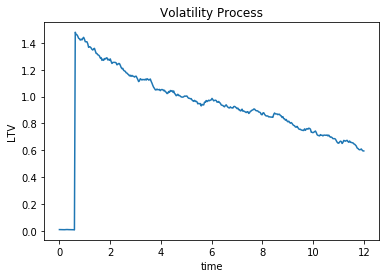

In [14]:
# vola process of this path
plot(time, v[6092])
xlabel('time')
ylabel('LTV')
plt.title('Volatility Process')
show()

In [15]:
# LTV and price, when collateral is sold
print(ltv[6092,np.argwhere(ltv[6092]>=0.9)[0]], s[6092,np.argwhere(ltv[6092]>=0.9)[0]])

[0.90718098] [6234.20475963]


In [16]:
# simulated BTC price range
minima = np.empty([n])
maxima = np.empty([n])
for k in range(n):
    minima[k] = min(s[k])
    maxima[k] = max(s[k])
    
print('Prices from ', round(min(minima),3), ' to ', round(max(maxima),3), sep="")

Prices from 1391.04 to 127056.152


## Determine Value of Lending Contract

In [17]:
# function for calculating the payoff of contract k at time t
def payoff(S, LTV, B0, K, z, t, T, r, k=0):
    B = (1+z)*B0             # total repayment
    CS_usd = B0/LTV[k,0]     # collateral size
    CS_btc = CS_usd/S[k,0]   # amount of bitcoin needed
    
    # find time points where LTV hits threshold
    tau = np.argwhere(LTV[k] >= K)
    
    if len(tau) == 0:
        F = exp(-r*(T-t)/T)*B
        
    else:
        F = exp(-r*((tau[0]-t)/T))*(CS_btc*S[k,tau[0]])
        
    return F

In [18]:
### contract parameters ###
# borrowed amount in USD
B0 = 10000

# pre-agreed interest rate
z = 0.1

# annual discounting factor
r = 0.01

# time point of view (in days)
t = m
K = 0.9

In [19]:
# calculate payoff for all contracts
F = np.empty((n))

for k in range(n):
    F[k]=payoff(s, ltv, B0, K, z, t, m, r, k)

In [20]:
# empirical mean of all contracts
mean = 1/n*sum(F)

# empirical variance
variance = 1/(n-1)*(sum((F-mean)**2))
sd = sqrt(variance)

print('mean payoff: ', round(mean, 3), sep="")
print('variance: ', round(variance, 3), ' with standard deviation ', round(sd, 3), sep="" )

mean payoff: 10998.925
variance: 929.316 with standard deviation 30.485


In [21]:
print('Minimal Payoff: ', round(min(F),3), sep="")
print('Maximal Payoff: ', round(max(F),3), sep="")

Minimal Payoff: 9422.147
Maximal Payoff: 11202.544


In [22]:
# which path gives maximum payoff
print(np.argwhere(F == max(F)))

# liquidization day of this particular path
np.argwhere(ltv[np.argwhere(F == max(F))] >= K)[0,2]

[[6956]]


56

In [23]:
print('Collateral is sold at ', round(ltv[6956,56],4), ' LTV for ', round(s[6956,56],3), ' USD.', sep="")

Collateral is sold at 0.9002 LTV for 6282.247 USD.


In [24]:
# therefore, the expected value of the contract is
V = exp(-r)*mean

# discounted value of the pre-agreed payback
b = exp(-r)*(B0*(1+z))

print('V = ', round(V, 2), sep="")  # contract value
print('b = ', round(b, 2), sep="")  # present value of repayment

V = 10889.48
b = 10890.55


In [27]:
# how many lenders lose money or gain more than the repayment amount?
gain = len(np.argwhere(F > B0*(1+z)))
loss = len(np.argwhere(F < B0))
print('Lender loses money in ', loss, ' cases, and earns in ', gain, ' cases.', sep="")

Lender loses money in 3 cases, and earns in 66 cases.


In [28]:
# how many borrowers lose their collateral?
i = 0
for k in range(n):
    if len(np.argwhere(ltv[k]>=K)) > 0:
        i += 1
print('Collateral is automatically liquidized in ', i, ' cases.', sep="")

Collateral is automatically liquidized in 134 cases.


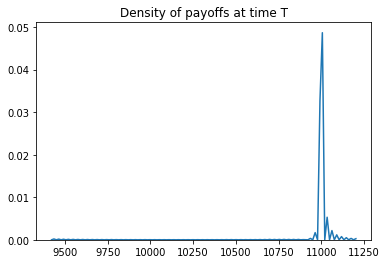

In [25]:
# distribution of payoffs
sns.distplot(F, hist=False, kde=True)
plt.title('Density of payoffs at time T')

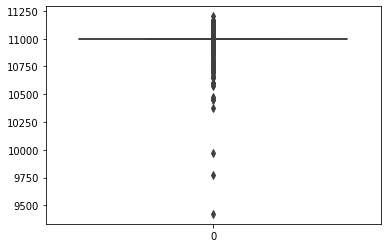

In [26]:
sns.boxplot(data=F);